In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


import mlflow
import mlflow.sklearn
import dagshub


Este conjunto de datos se utiliza para la segmentación de fases de gestos en videos grabados con un sensor Microsoft Kinect. El dataset ya ha sido preprocesado, con los archivos conteniendo información tanto en forma de posiciones espaciales (coordenadas X, Y, Z) de puntos de articulación clave (manos, muñeca, cabeza y columna) como de velocidades y aceleraciones vectoriales y escalares de las extremidades.

El objetivo principal de este dataset es predecir las fases de gestos en una secuencia temporal, categorizando cada momento de la gesticulación en una de las siguientes clases: Descanso (D), Preparación (P), Golpe (S), Sujeción (H) y Retracción (R). Estas fases corresponden a diferentes etapas de un gesto, como el inicio, el movimiento y el retorno del gesto. El desafío es utilizar esta información para entrenar modelos que puedan segmentar correctamente los gestos a partir de las posiciones y movimientos de las extremidades, lo que se traduce en una clasificación precisa de cada fase en un video.

Estos videos fueron segmentados manualmente por expertos, lo que proporciona un conjunto de ground truth necesario para entrenar y evaluar modelos de predicción.

1-18: Posiciones (X, Y, Z) de 6 puntos de articulación: mano izquierda, mano derecha, muñeca izquierda, muñeca derecha, cabeza, columna vertebral.
19: timestamp: Marca de tiempo de cada frame.
20-32: Velocidades y aceleraciones vectoriales y escalares de las manos y muñecas (X, Y, Z).

Cada fila corresponde a un frame de video y contiene estas características para clasificar la fase del gesto.

In [147]:
folder_path = "C:/Users/Finar/One_finarq_staf/OneDrive/Documentos/Proyecto Modelos/proyecto-modelos/data/Classification"

In [148]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('_va3.csv')]

In [4]:
dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)


In [107]:
df = pd.concat(dfs, ignore_index=True)

In [108]:
df

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,Phase
0,-0.005009,-0.000964,0.000573,0.008623,0.005667,0.001302,-0.000631,0.000130,-0.000048,0.007762,...,1.880800e-04,0.005133,0.010400,0.000646,0.007871,0.004631,0.000963,0.000092,0.000438,D
1,0.004905,0.001209,-0.000649,0.004737,0.003166,0.000819,-0.000572,-0.000015,0.000023,0.002706,...,-7.500000e-07,0.005093,0.005756,0.000573,0.003459,0.000730,0.000332,0.000012,0.000433,D
2,-0.002393,-0.000216,0.000136,0.003028,0.001212,0.000336,-0.000449,0.000017,0.000047,0.002868,...,-3.920000e-05,0.002406,0.003279,0.000452,0.003261,0.002412,0.000852,0.000042,0.000202,D
3,-0.001394,-0.000242,0.000056,0.001182,0.000575,0.000225,-0.000479,-0.000050,0.000104,0.001171,...,-3.184000e-05,0.001416,0.001334,0.000493,0.001358,0.000313,0.000611,0.000029,0.000596,D
4,-0.000156,-0.000004,0.000023,0.001585,0.000630,0.000094,-0.000303,0.000097,0.000065,0.001579,...,-2.015000e-05,0.000158,0.001709,0.000325,0.001713,0.000203,0.000069,0.000038,0.000069,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9868,-0.003709,-0.006168,0.000786,-0.000155,0.001088,-0.000144,-0.003815,-0.004658,0.000656,0.000060,...,-9.400000e-07,0.007240,0.001109,0.006056,0.000173,0.001976,0.000137,0.001575,0.000051,D
9869,-0.000727,0.001536,-0.000211,0.000700,-0.000975,0.000067,-0.001147,0.000177,0.000008,0.000423,...,1.234000e-05,0.001712,0.001202,0.001160,0.000515,0.002600,0.000701,0.001738,0.000124,D
9870,0.003074,0.007870,-0.000962,0.000526,-0.000779,0.000090,0.002786,0.005035,-0.000606,0.000413,...,2.327000e-05,0.008504,0.000944,0.005786,0.000431,0.002007,0.000071,0.001697,0.000112,D
9871,0.003297,0.008467,-0.001035,0.000578,-0.000740,0.000101,0.002947,0.005385,-0.000652,0.000580,...,1.541000e-05,0.009145,0.000944,0.006173,0.000699,0.000229,0.000023,0.000139,0.000113,D


In [109]:
df.isnull().sum().sum()

np.int64(0)

In [110]:
class_distribution = df['Phase'].value_counts()
class_distribution

Phase
S    2950
D    2741
P    2097
R    1087
H     998
Name: count, dtype: int64

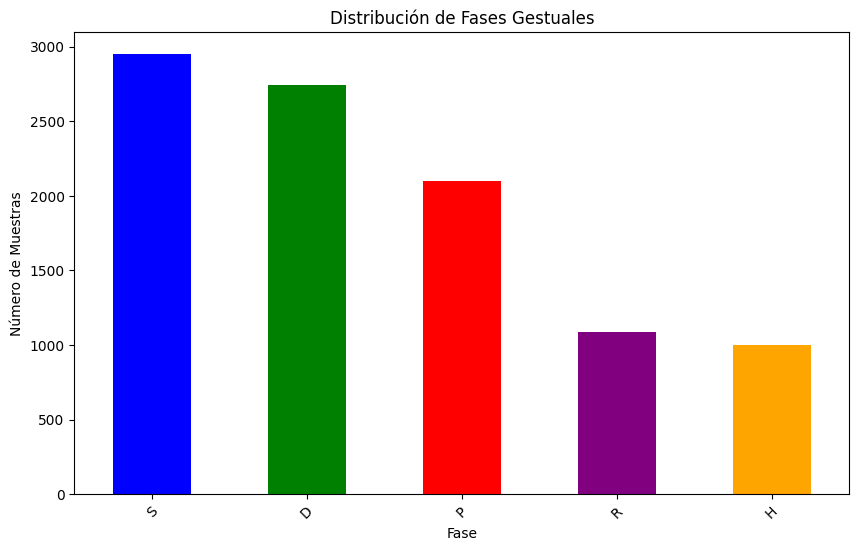

In [111]:
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Distribución de Fases Gestuales')
plt.xlabel('Fase')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)
plt.show()

Antriormente se pudo observar que existe un desblanceo en las clases debido a a muestra claramente que algunas clases tienen miles de muestras (2500-3000) mientras otras tienen significativamente menos (500-1000 o menos).La clase mayoritaria parece tener aproximadamente 6 veces más muestras que las clases minoritarias, lo que constituye un desbalanceo severo. Esto puede afectar a nuestros modelos.

Como solución se implementará una técnica combinada de SMOTE y undersampling, que consistirá en aumentar las clases minoritarias (H, R, P) para mejorar su representación y reducir el sesgo del modelo hacia las clases mayoritarias. Las clases mayoritarias (D, S) serán ligeramente reducidas para evitar que dominen el entrenamiento, manteniendo un equilibrio que permita un aprendizaje más justo y efectivo sin perder información relevante. Esta estrategia se aplicará exclusivamente sobre el conjunto de datos de entrenamiento para preservar la validez de la evaluación del modelo. La cantidad de datos para cada clase fue seleccionada considerando el tamaño original de las clases en el entrenamiento, asegurando que las clases minoritarias se incrementen de forma razonable sin generar un exceso de datos sintéticos, mientras que las mayoritarias se ajustan para mantener una proporción equilibrada y evitar sobreajuste.

In [112]:
#Separar en X and Y 
X = df.drop('Phase', axis=1) 
y = df['Phase']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [114]:
print("Distribución original de y:")
print(y.value_counts())
print("\nDistribución en y_train:")
print(y_train.value_counts())
print("\nDistribución en y_test:")
print(y_test.value_counts())

Distribución original de y:
Phase
S    2950
D    2741
P    2097
R    1087
H     998
Name: count, dtype: int64

Distribución en y_train:
Phase
S    2065
D    1919
P    1468
R     761
H     698
Name: count, dtype: int64

Distribución en y_test:
Phase
S    885
D    822
P    629
R    326
H    300
Name: count, dtype: int64


In [115]:
def balancear_clases(X_train, y_train, verbose=True):
    over = {
        'H': 2000,
        'R': 2100,
        'P': 2400,
    }

    under = {
        'D': y_train.value_counts()['D'], 
        'S': y_train.value_counts()['S'],
    }

    smote = SMOTE(sampling_strategy=over, random_state=42)
    undersampler = RandomUnderSampler(sampling_strategy=under, random_state=42)

    pipeline = Pipeline(steps=[('smote', smote), ('under', undersampler)])

    X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)

    if verbose:
        print("\nDistribución balanceada:")
        print(pd.Series(y_train_bal).value_counts())

    return X_train_bal, y_train_bal

In [116]:
X_train_bal, y_train_bal = balancear_clases(X_train, y_train)


Distribución balanceada:
Phase
P    2400
R    2100
S    2065
H    2000
D    1919
Name: count, dtype: int64


In [117]:
X_train = X_train_bal
y_train = y_train_bal

In [118]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10484, 32), (10484,), (2962, 32), (2962,))

In [234]:
dagshub.init(url="https://dagshub.com/daduke1/proyecto-modelos", mlflow=True)

MLFLOW_TRACKING_URI = mlflow.get_tracking_uri()

print(MLFLOW_TRACKING_URI)

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(experiment_name="clasificacion")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto 
Modelos\proyecto-modelos\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=54bb814d-e414-43b7-ba24-8d18c1c47b2e&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=d9c3e34d469185b063b81bd61cb4e7946cd8f7d88905b80a91b8fdb5c766dbbc




Accessing as wolburg

Initialized MLflow to track repo "daduke1/proyecto-modelos"

Repository daduke1/proyecto-modelos initialized!

https://dagshub.com/daduke1/proyecto-modelos.mlflow


2025/05/14 20:56:05 INFO mlflow.tracking.fluent: Experiment with name 'clasificacion' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/b68653da84764d07beff7c64a5cbf7b9', creation_time=1747277765231, experiment_id='3', last_update_time=1747277765231, lifecycle_stage='active', name='clasificacion', tags={}>

In [ ]:
def train_and_log_models(X_train, y_train, X_test, y_test):
    models = {
        'knn': KNeighborsClassifier(n_neighbors=3),
        'cart': DecisionTreeClassifier(),
        'svm': SVC(),
        'bayes': GaussianNB(),
        'bag': BaggingClassifier(n_estimators=100),
        'rf': RandomForestClassifier(n_estimators=100),
        'et': ExtraTreesClassifier(n_estimators=100),
        'gbm': GradientBoostingClassifier(n_estimators=100)
    }

    reports = {}

    for name, model in models.items():
        with mlflow.start_run(run_name=name):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            mlflow.log_metric("accuracy", acc)

            report_str = classification_report(y_test, y_pred)
            reports[name] = report_str

            mlflow.log_param("classification_report", report_str)

            mlflow.sklearn.log_model(model, artifact_path=name)

    return reports


In [236]:
resultados = train_and_log_models(X_train_bal, y_train_bal, X_test, y_test)

2025/05/14 20:57:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run knn at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/eb3925e26c1146e78cd6048da87d8ae7
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


2025/05/14 20:57:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run cart at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/15175e49b20649a09f6cf092cd07c58d
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


2025/05/14 20:57:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run svm at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/2a2bf0c52eca4120a6a48477b069ca38
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


2025/05/14 20:57:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bayes at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/e8215dd768c542cb922f81c4f1fb6195
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


2025/05/14 20:58:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bag at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/a04d49ecefda428488e3eb9106b1694e
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


2025/05/14 20:59:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/bc8ea1b3b7ae4cb08c54abff262e17bc
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


2025/05/14 20:59:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run et at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/14b8881d5f4744a9bd009cb3b8b0e85f
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


2025/05/14 21:01:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gbm at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/c9582dd8949f495ca72621c899a8c404
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3


In [237]:
items = list(resultados.items())
for i in range(0, 2):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de knn:
              precision    recall  f1-score   support

           D       0.68      0.71      0.70       822
           H       0.46      0.63      0.53       300
           P       0.55      0.58      0.56       629
           R       0.43      0.59      0.50       326
           S       0.75      0.50      0.60       885

    accuracy                           0.60      2962
   macro avg       0.58      0.60      0.58      2962
weighted avg       0.63      0.60      0.60      2962

Reporte de cart:
              precision    recall  f1-score   support

           D       0.66      0.57      0.61       822
           H       0.32      0.39      0.35       300
           P       0.44      0.42      0.43       629
           R       0.37      0.48      0.42       326
           S       0.55      0.52      0.53       885

    accuracy                           0.50      2962
   macro avg       0.47      0.48      0.47      2962
weighted avg       0.51      0.50      0.50 

In [238]:
items = list(resultados.items())
for i in range(0, 2):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de knn:
              precision    recall  f1-score   support

           D       0.68      0.71      0.70       822
           H       0.46      0.63      0.53       300
           P       0.55      0.58      0.56       629
           R       0.43      0.59      0.50       326
           S       0.75      0.50      0.60       885

    accuracy                           0.60      2962
   macro avg       0.58      0.60      0.58      2962
weighted avg       0.63      0.60      0.60      2962

Reporte de cart:
              precision    recall  f1-score   support

           D       0.66      0.57      0.61       822
           H       0.32      0.39      0.35       300
           P       0.44      0.42      0.43       629
           R       0.37      0.48      0.42       326
           S       0.55      0.52      0.53       885

    accuracy                           0.50      2962
   macro avg       0.47      0.48      0.47      2962
weighted avg       0.51      0.50      0.50 

In [239]:
for i in range(2, 4):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de svm:
              precision    recall  f1-score   support

           D       0.59      0.68      0.63       822
           H       0.28      0.36      0.31       300
           P       0.45      0.50      0.47       629
           R       0.40      0.63      0.49       326
           S       0.71      0.34      0.45       885

    accuracy                           0.50      2962
   macro avg       0.48      0.50      0.47      2962
weighted avg       0.54      0.50      0.50      2962

Reporte de bayes:
              precision    recall  f1-score   support

           D       0.48      0.27      0.35       822
           H       0.16      0.71      0.26       300
           P       0.39      0.22      0.28       629
           R       0.29      0.22      0.25       326
           S       0.57      0.34      0.43       885

    accuracy                           0.32      2962
   macro avg       0.38      0.35      0.31      2962
weighted avg       0.44      0.32      0.34

In [240]:
for i in range(4, 6):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de bag:
              precision    recall  f1-score   support

           D       0.75      0.78      0.77       822
           H       0.58      0.61      0.60       300
           P       0.61      0.57      0.59       629
           R       0.51      0.64      0.57       326
           S       0.70      0.63      0.66       885

    accuracy                           0.66      2962
   macro avg       0.63      0.65      0.64      2962
weighted avg       0.66      0.66      0.66      2962

Reporte de rf:
              precision    recall  f1-score   support

           D       0.74      0.80      0.77       822
           H       0.56      0.57      0.56       300
           P       0.61      0.58      0.59       629
           R       0.51      0.62      0.56       326
           S       0.72      0.63      0.67       885

    accuracy                           0.66      2962
   macro avg       0.63      0.64      0.63      2962
weighted avg       0.66      0.66      0.66   

In [241]:
for i in range(6, 8):
    model_name, report = items[i]
    print(f"Reporte de {model_name}:\n{report}")
    print("="*70)


Reporte de et:
              precision    recall  f1-score   support

           D       0.73      0.86      0.79       822
           H       0.70      0.57      0.63       300
           P       0.65      0.58      0.61       629
           R       0.57      0.56      0.57       326
           S       0.71      0.71      0.71       885

    accuracy                           0.69      2962
   macro avg       0.67      0.65      0.66      2962
weighted avg       0.69      0.69      0.69      2962

Reporte de gbm:
              precision    recall  f1-score   support

           D       0.71      0.64      0.67       822
           H       0.36      0.57      0.44       300
           P       0.49      0.53      0.51       629
           R       0.41      0.65      0.50       326
           S       0.69      0.43      0.53       885

    accuracy                           0.55      2962
   macro avg       0.53      0.56      0.53      2962
weighted avg       0.59      0.55      0.55   

Extra Trees, Random Forest y BAG lograron las mejores precisiones 70% y 66% y 66% debido a su capacidad para manejar relaciones complejas y balancear clases. Modelos simples como Naive Bayes con 32% y Decision Tree con 50% rindieron peor, probablemente por su menor capacidad para capturar patrones complejos y desequilibrios. Esto indica que los métodos ensemble son más adecuados para este dataset.

Para los modelos de redes neuronales el flujo que se seguira es el siguente:
Claro, aquí tienes el párrafo en futuro, describiendo el flujo que se seguirá:

Se definirá para cada modelo (MLP, CNN, LSTM y CNN-LSTM) una función que construya su arquitectura específica, permitiendo flexibilidad y facilidad para experimentar. Después, se implementará una función de entrenamiento que incluya la normalización de los datos con StandardScaler para mejorar la estabilidad y velocidad de aprendizaje, así como la codificación de las etiquetas con LabelEncoder. Durante el entrenamiento, se usará EarlyStopping para evitar sobreajuste, y se registrarán métricas y parámetros en MLflow para llevar un seguimiento ordenado y comparativo de los experimentos. Finalmente, se realizarán predicciones sobre los datos de prueba normalizados, se evaluará el desempeño con métricas clásicas de clasificación y se graficarán comparaciones entre etiquetas reales y predichas, asegurando así un proceso reproducible, estructurado y eficiente para la evaluación y mejora continua de los modelos.


# MLP

In [243]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [244]:
X_train.shape,X_test.shape,X_val.shape, y_train.shape,y_test.shape,y_val.shape

((4293, 32), (2962, 32), (1074, 32), (4293,), (2962,), (1074,))

In [305]:
def build_mlp_classifier(input_shape, num_classes):
    model = Sequential()
    
    model.add(Dense(256, input_shape=(input_shape,), kernel_regularizer=l2(0.001))) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5)) 

    model.add(Dense(512, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))

    model.add(Dense(256, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    model.add(Dense(128, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.0005),  
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
def train_mlp_mlflow(X_train, y_train, X_val, y_val, X_test, input_shape, num_classes):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)  
   
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)

    model = build_mlp_classifier(input_shape, num_classes)
    early_stop = EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)
    
    with mlflow.start_run(run_name="MLP_With_Scaling"):
        history = model.fit(
            X_train_scaled, y_train_enc,
            validation_data=(X_val_scaled, y_val_enc),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stop]
        )

        loss, accuracy = model.evaluate(X_val_scaled, y_val_enc, verbose=0)
        
        mlflow.log_params({"input_shape": input_shape, "scaler": "StandardScaler"})
        mlflow.log_metric("val_loss", loss)
        mlflow.log_metric("val_accuracy", accuracy)
        mlflow.keras.log_model(model, "model_MLP")
    
    y_pred_proba = model.predict(X_test_scaled)
    y_pred = y_pred_proba.argmax(axis=1) 
    print(classification_report(le.transform(y_test), y_pred, target_names=le.classes_))

    return model, le, scaler


In [307]:
input_shape = X_train.shape[1] 
num_classes = len(np.unique(y_train)) 

model, le, scaler = train_mlp_mlflow(X_train, y_train, X_val, y_val, X_test, input_shape, num_classes)


c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.2767 - loss: 2.6921 - val_accuracy: 0.3669 - val_loss: 2.3646
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3610 - loss: 2.4306 - val_accuracy: 0.3771 - val_loss: 2.3242
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3790 - loss: 2.3256 - val_accuracy: 0.4115 - val_loss: 2.2570
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4032 - loss: 2.2959 - val_accuracy: 0.4236 - val_loss: 2.2188
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3847 - loss: 2.2641 - val_accuracy: 0.4302 - val_loss: 2.1864
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4010 - loss: 2.2137 - val_accuracy: 0.4274 - val_loss: 2.1394
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4142 - loss: 2.1555 - val_accuracy: 0.4283 - val_loss: 2.1036
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4399 - loss: 2.1140 - 

2025/05/14 22:51:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/14 22:51:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MLP_With_Scaling at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/8caa74454c65421891aa6c57025e52be
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           D       0.65      0.37      0.47       822
           H       0.24      0.69      0.36       300
           P       0.46      0.45      0.46       629
           R       0.33      0.64      0.44       326
           S       0.68      0.30      0.42       885

    accuracy                           0.43      2962
   macro avg       0.47      0.49      0.43      2962
weighted avg       0.54      0.43      0.44      2962



93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


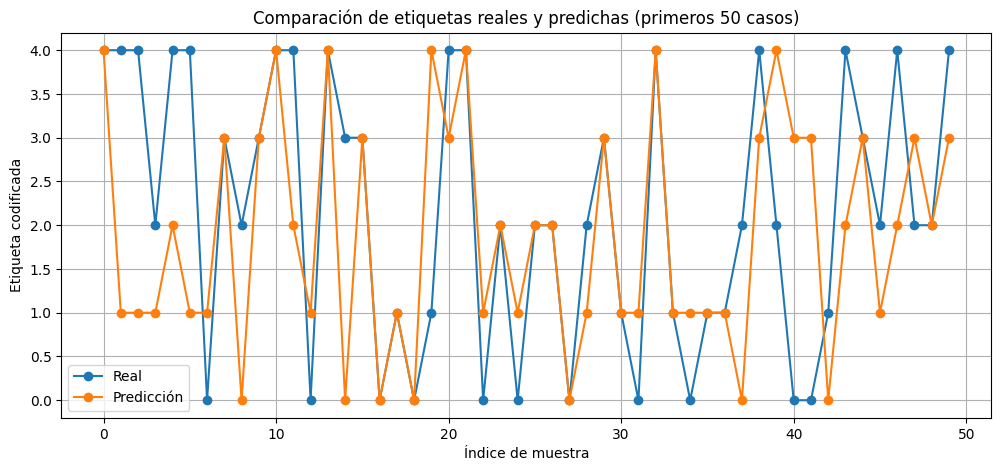

In [308]:
y_test_enc = le.transform(y_test)

X_test_scaled = scaler.transform(X_test) 


y_pred_proba = model.predict(X_test_scaled)
y_pred = y_pred_proba.argmax(axis=1)

indices = np.arange(50)

plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_enc[:50], label='Real', marker='o')
plt.plot(indices, y_pred[:50], label='Predicción', marker='o')
plt.title('Comparación de etiquetas reales y predichas (primeros 50 casos)')
plt.xlabel('Índice de muestra')
plt.ylabel('Etiqueta codificada')
plt.legend()
plt.grid(True)
plt.show()

# CNN

In [312]:
def build_cnn_classifier(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [320]:
def train_cnn_mlflow(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
    X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)
    
    
    model = build_cnn_classifier(input_shape, num_classes) 
    
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    with mlflow.start_run(run_name="CNN_With_Scaling"):
        history = model.fit(
            X_train_cnn, y_train_enc,
            validation_data=(X_val_cnn, y_val_enc),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stop]
        )
        
        loss, accuracy = model.evaluate(X_val_cnn, y_val_enc, verbose=0)
        
        mlflow.log_params({"input_shape": input_shape, "scaler": "StandardScaler"})
        mlflow.log_metric("val_loss", loss)
        mlflow.log_metric("val_accuracy", accuracy)
        mlflow.keras.log_model(model, "cnn_model")
    
    y_pred_proba = model.predict(X_test_cnn)
    y_pred = y_pred_proba.argmax(axis=1)
    
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    
    return model, history, le, scaler


In [321]:
input_shape = (X_train.shape[1], 1)  # recuerda el reshape para CNN
num_classes = len(np.unique(y_train))

model, history, le, scaler = train_cnn_mlflow(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes)


c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.2488 - loss: 2.3776 - val_accuracy: 0.2188 - val_loss: 2.1643
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2974 - loss: 2.0883 - val_accuracy: 0.3454 - val_loss: 2.0062
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3398 - loss: 1.9970 - val_accuracy: 0.3529 - val_loss: 1.9269
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3456 - loss: 1.9361 - val_accuracy: 0.4097 - val_loss: 1.8407
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3647 - loss: 1.8685 - val_accuracy: 0.4246 - val_loss: 1.7638
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3849 - loss: 1.8102 - val_accuracy: 0.4218 - val_loss: 1.7345
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3909 - loss: 1.7436 - val_accuracy: 0.4451 - val_loss: 1.6750
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3969 - loss: 1.7003 -

2025/05/14 23:21:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/14 23:21:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run CNN_With_Scaling at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/31667819133644febc75cf6dcf5f3f3d
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           D       0.64      0.69      0.66       822
           H       0.40      0.42      0.41       300
           P       0.43      0.52      0.47       629
           R       0.36      0.63      0.46       326
           S       0.66      0.32      0.43       885

    accuracy                           0.51      2962
   macro avg       0.50      0.52      0.49      2962
weighted avg       0.55      0.51      0.51      2962



93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


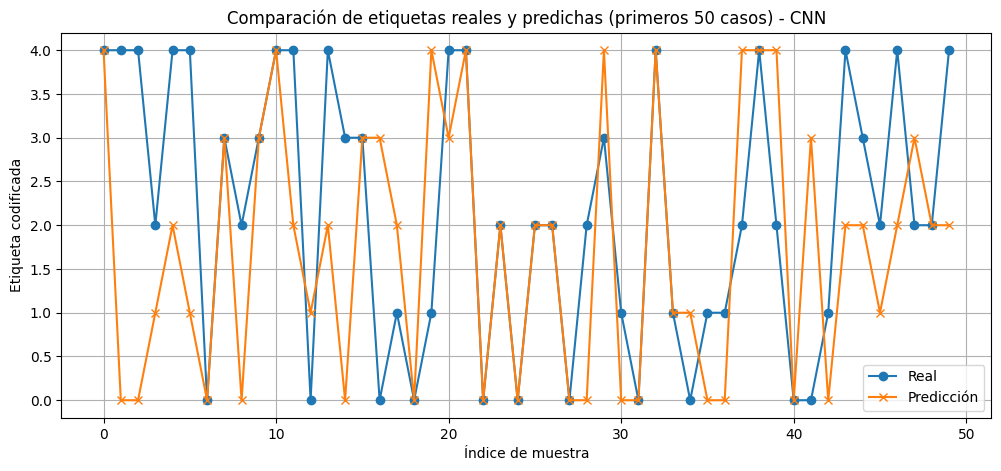

In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_enc = le.transform(y_test)
y_pred_proba = model.predict(X_test_cnn)
y_pred = y_pred_proba.argmax(axis=1)

indices = np.arange(50)


plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_enc[:50], label='Real', marker='o')
plt.plot(indices, y_pred[:50], label='Predicción', marker='x')
plt.title('Comparación de etiquetas reales y predichas (primeros 50 casos) - CNN')
plt.xlabel('Índice de muestra')
plt.ylabel('Etiqueta codificada')
plt.legend()
plt.grid(True)
plt.show()

# LSTM

In [ ]:
def build_lstm_classifier(input_shape, num_classes):
    model = Sequential()
    
   
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    
    
    model.add(LSTM(64, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    
    
    model.add(Dense(64, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))
    
   
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [326]:
def train_lstm_mlflow(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes):

   
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Redimensionar para LSTM: (samples, timesteps, features)
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
    # Codificación de etiquetas
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)
    
    # Construir modelo LSTM
    model = build_lstm_classifier(input_shape, num_classes)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    with mlflow.start_run(run_name="LSTM_With_Scaling"):
        history = model.fit(
            X_train_lstm, y_train_enc,
            validation_data=(X_val_lstm, y_val_enc),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stop]
        )
        
        loss, accuracy = model.evaluate(X_val_lstm, y_val_enc, verbose=0)
        
        mlflow.log_params({"input_shape": input_shape, "scaler": "StandardScaler"})
        mlflow.log_metric("val_loss", loss)
        mlflow.log_metric("val_accuracy", accuracy)
        mlflow.keras.log_model(model, "lstm_model")
    
    y_pred_proba = model.predict(X_test_lstm)
    y_pred = y_pred_proba.argmax(axis=1)
    
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    
    return model, history, le, scaler


In [327]:
input_shape = (X_train.shape[1], 1)  
num_classes = len(np.unique(y_train))  
model, history, le, scaler = train_lstm_mlflow(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes)


c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.2957 - loss: 1.8293 - val_accuracy: 0.2840 - val_loss: 1.7954
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.3479 - loss: 1.6717 - val_accuracy: 0.2616 - val_loss: 1.7961
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.3711 - loss: 1.5927 - val_accuracy: 0.3073 - val_loss: 1.6586
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.3943 - loss: 1.5553 - val_accuracy: 0.3669 - val_loss: 1.5881
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.3801 - loss: 1.5463 - val_accuracy: 0.2877 - val_loss: 1.6670
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.3808 - loss: 1.5217 - val_accuracy: 0.3603 - val_loss: 1.6237
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.3741 - loss: 1.5118 - val_accuracy: 0.3939 - val_loss: 1.5204
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.3973 - loss: 1.4824 -

2025/05/14 23:37:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/14 23:38:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LSTM_With_Scaling at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/cc46a36e9d54480c8bdc452c1d356034
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
              precision    recall  f1-score   support

           D       0.57      0.33      0.42       822
           H       0.18      0.54      0.27       300
           P       0.43      0.36      0.39       629
           R       0.31      0.52      0.39       326
           S       0.56      0.32      0.41       885

    accuracy                           0.38      2962
   macro avg       0.41      0.41      0.37      2962
weighted avg       0.47      0.38      0.39      2962



93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


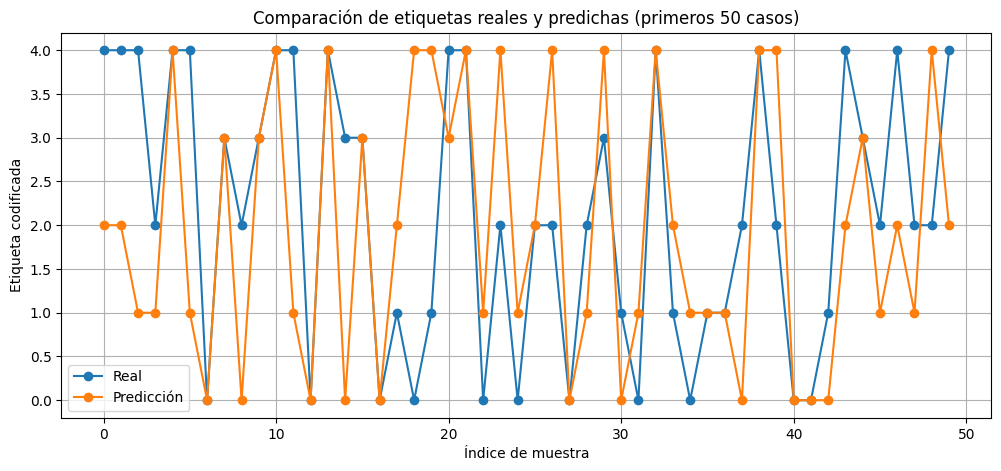

In [329]:
X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_enc = le.transform(y_test)
y_pred_proba = model.predict(X_test_lstm)
y_pred = y_pred_proba.argmax(axis=1)

indices = np.arange(50)

plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_enc[:50], label='Real', marker='o')
plt.plot(indices, y_pred[:50], label='Predicción', marker='o')
plt.title('Comparación de etiquetas reales y predichas (primeros 50 casos)')
plt.xlabel('Índice de muestra')
plt.ylabel('Etiqueta codificada')
plt.legend()
plt.grid(True)
plt.show()


# CNN-LSTM

In [331]:
def build_cnn_lstm_classifier(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.4))
    
    model.add(Dense(64, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [333]:
def train_cnn_lstm_mlflow(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
   
    X_train_cnn_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_cnn_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
    X_test_cnn_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
    
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)
    
   
    model = build_cnn_lstm_classifier(input_shape, num_classes)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    with mlflow.start_run(run_name="CNN_LSTM"):
        history = model.fit(
            X_train_cnn_lstm, y_train_enc,
            validation_data=(X_val_cnn_lstm, y_val_enc),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stop]
        )
        
        loss, accuracy = model.evaluate(X_val_cnn_lstm, y_val_enc, verbose=0)
        
        mlflow.log_params({"input_shape": input_shape, "scaler": "StandardScaler"})
        mlflow.log_metric("val_loss", loss)
        mlflow.log_metric("val_accuracy", accuracy)
        mlflow.keras.log_model(model, "cnn_lstm_model")
    
    y_pred_proba = model.predict(X_test_cnn_lstm)
    y_pred = y_pred_proba.argmax(axis=1)
    
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    
    return model, history, le, scaler


In [334]:
input_shape = (X_train.shape[1], 1)  
num_classes = len(np.unique(y_train))  
model, history, le, scaler = train_cnn_lstm_mlflow(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes)


c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Finar\One_finarq_staf\OneDrive\Documentos\Proyecto Modelos\proyecto-modelos\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2737 - loss: 1.7125 - val_accuracy: 0.3175 - val_loss: 1.6447
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3330 - loss: 1.6213 - val_accuracy: 0.3566 - val_loss: 1.5796
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3605 - loss: 1.5675 - val_accuracy: 0.3957 - val_loss: 1.5220
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3845 - loss: 1.5163 - val_accuracy: 0.3994 - val_loss: 1.4951
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4051 - loss: 1.4900 - val_accuracy: 0.4125 - val_loss: 1.4582
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4072 - loss: 1.4602 - val_accuracy: 0.4143 - val_loss: 1.4588
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4042 - loss: 1.4514 - val_accuracy: 0.4069 - val_loss: 1.4448
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4256 - loss: 1.4163 -

2025/05/14 23:49:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/14 23:49:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run CNN_LSTM at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3/runs/b736bab5bef041448886f255c72e44ec
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           D       0.61      0.74      0.67       822
           H       0.37      0.38      0.38       300
           P       0.48      0.45      0.46       629
           R       0.39      0.60      0.47       326
           S       0.63      0.40      0.49       885

    accuracy                           0.52      2962
   macro avg       0.49      0.51      0.49      2962
weighted avg       0.54      0.52      0.52      2962



93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


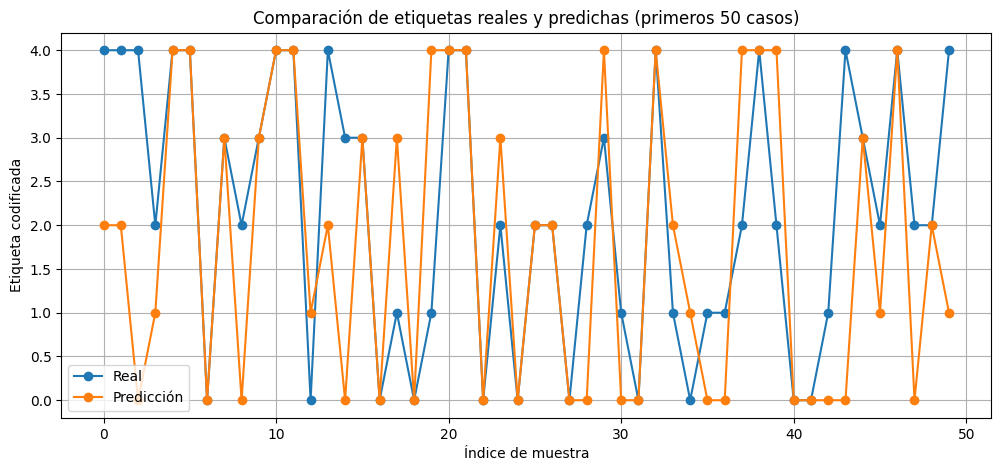

In [335]:
X_test_scaled = scaler.transform(X_test)
X_test_cnn_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_enc = le.transform(y_test)
y_pred_proba = model.predict(X_test_cnn_lstm)
y_pred = y_pred_proba.argmax(axis=1)

indices = np.arange(50)

plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_enc[:50], label='Real', marker='o')
plt.plot(indices, y_pred[:50], label='Predicción', marker='o')
plt.title('Comparación de etiquetas reales y predichas (primeros 50 casos)')
plt.xlabel('Índice de muestra')
plt.ylabel('Etiqueta codificada')
plt.legend()
plt.grid(True)
plt.show()


Los modelos evaluados muestran desempeños variados, donde la combinación CNN-LSTM obtuvo la mejor precisión global con un accuracy del 52%, seguido por la CNN pura con 51%. Esto indica que integrar capas convolucionales con secuenciales LSTM ayuda a capturar mejor tanto patrones locales como temporales en los datos. Por otro lado, el MLP y LSTM simples tuvieron un desempeño menor, con accuracies de 43% y 38%, respectivamente, reflejando que los modelos densos o solo secuenciales no son tan efectivos para esta tarea específica.

Para mejorar los modelos, se pueden explorar técnicas de ajuste hiperparamétrico como optuna. Tambien seria util probar arquitecturas más profundas y experimentar con distintas estrategias de preprocesamiento, como normalización mas precisa o técnicas de aumento de datos para clases minoritarias mas avanzadas.

Los modelos como Extra Trees, Random Forest y Bagging fueron los que mejor se ajustaron, logrando precisiones de hasta 70% gracias a su capacidad para manejar relaciones complejas y balancear clases, superando a modelos simples como Naive Bayes y Decision Tree. Entre las redes neuronales para series de tiempo, la arquitectura CNN-LSTM obtuvo el mejor desempeño con 52% de accuracy, aprovechando la extracción espacial y temporal de datos. En general, los métodos ensemble son más efectivos para este dataset, aunque las redes profundas muestran potencial para mejoras futuras con más datos y ajuste.